In [1]:
import torch as t
import pandas as pd
import numpy as np
import torch.nn as nn 
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from torchvision import transforms as trf
from torch.utils.data import Dataset , DataLoader
from torchvision.io import read_image
import torch.nn.functional as F
import os 


c:\Users\SalmaneElFtouh\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\SalmaneElFtouh\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\SalmaneElFtouh\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
print(t.cuda.is_available())
print(t.__version__)

if t.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = t.device(dev)  
print(device)
print(t.cuda.get_device_name(0))
print(t.cuda.get_device_properties(0))

True
1.13.0+cu117
cuda:0
NVIDIA GeForce RTX 2060
_CudaDeviceProperties(name='NVIDIA GeForce RTX 2060', major=7, minor=5, total_memory=6143MB, multi_processor_count=30)


In [3]:
bs=32
class CustomDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 7])
        image = (read_image(img_path)/255)
        
        label = t.tensor(self.img_labels.iloc[idx, 6])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

training_data=CustomDataset('data_set/Train.csv','data_set',trf.Resize((25,25)))
test_data=CustomDataset('data_set/Test.csv','data_set',trf.Resize((25,25)))

train_dataloader = DataLoader(training_data, batch_size=bs, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=bs, shuffle=True)

In [4]:
N=50*7*7
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 50, kernel_size=3, padding =2)
        self.conv2 = nn.Conv2d(50, 50, kernel_size=3, padding =2)
        self.fc1 = nn.Linear(N, 50)
        self.fc2 = nn.Linear(50, 43)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, N)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [5]:
#model = CNN()
model_name='model_nn_v2.mdl'
model=t.load(model_name)
model=model.to(device)

optimizer = t.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
#optimizer = t.optim.Adam(model.parameters(), lr = 0.001)


# on sélectionne les log vraisemblances pour les vraies classes:
#loss_fn =  t.nn.NLLLoss()
loss_fn =  nn.CrossEntropyLoss()

In [6]:
import time
time_ = time.time()

train_losses = []
train_accs = []

# boucle d'apprentissage:
for epoch in range(50):
    print('epoch :' + str(epoch))
    
    running_loss_train = 0.
    running_corrects_train = 0.
    
    # entraînement
    for x, label in tqdm(train_dataloader):
        
        x=x.to(device)
        label=label.to(device)
        optimizer.zero_grad()
        output = model(x)
        #print(output.shape,label.shape)

        l = loss_fn(output, label)
        l.backward()     
        optimizer.step()

        #prédictions:
        _, preds = t.max(output, 1)

        #print(output.is_cuda,x.is_cuda,label.is_cuda)
        # compteurs
        running_loss_train += l.item() * x.shape[0]
        running_corrects_train += t.sum(preds == label.data).cpu()

    # calcul et stockage des scores d'entraînement

    epoch_loss_train = running_loss_train / len(training_data)
    epoch_acc_train = running_corrects_train.float() / len(training_data)

    train_losses.append(epoch_loss_train)
    train_accs.append(epoch_acc_train)
    if len(train_accs)==1 or train_accs[-1]>train_accs[-2]:
        t.save(model,f'./{model_name}')

    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        'train', epoch_loss_train, epoch_acc_train))


    new_t = time.time()
    print('time ' +str(round(new_t- time_)))
    time_ = new_t

print(train_losses,train_accs)

epoch :0


  0%|          | 0/1226 [00:00<?, ?it/s]

torch.Size([32, 3, 25, 25])


  0%|          | 0/1226 [00:09<?, ?it/s]


KeyboardInterrupt: 

In [ ]:

t.save(model,f'./{model_name}')

In [ ]:

test_loss=0
for x,label in tqdm(test_dataloader):
#x,label=next(iter(test_dataloader))
    with t.no_grad():
        x=x.to(device)
        label=label.to(device)
        out=model(x)
    _,i=t.max(out,dim=1)
    test_loss+=t.where((i-label)!=0)[0].size(dim=0)
test_loss/=len(test_data)
print('Accuracy : ',1-test_loss)

100%|██████████| 395/395 [00:13<00:00, 30.30it/s]

Accuracy :  0.894695170229612


In [ ]:

x,label=next(iter(test_dataloader))
with t.no_grad():
    x=x.to(device)
    label=label.to(device)
    out=model(x)
_,i=t.max(out,dim=1)


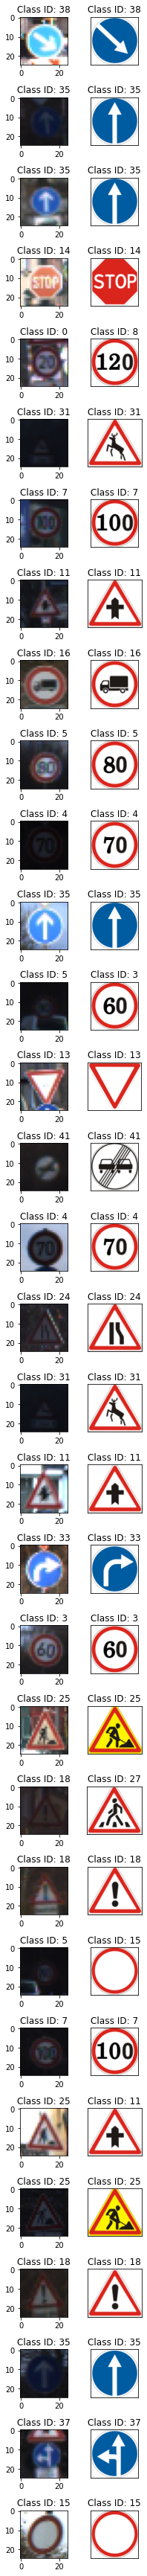

In [ ]:

len_bs=2*i.size(dim=0)
plt.figure(figsize=(3, 3*len_bs//2))
for index,j in enumerate(i):
    image = read_image("data_set/"+str(meta.iloc[int(j),0]))[:,:,:].permute(1,2,0)
    plt.subplot(len_bs,2,2*index+1)
    plt.tight_layout()
    plt.imshow(x[index,:,:,:].cpu().permute(1,2,0))
    plt.title(f"Class ID: {label[index].cpu()}")
    plt.subplot(len_bs,2,2*index+2)
    plt.imshow(image)
    plt.title(f"Class ID: {j}")
    plt.xticks([])
    plt.yticks([])
